# Requirement 5
## *Slightly non-stationary environments with multiple products*

In [185]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import optimize

### Environment

A slighly non-stationary environment, at a high level:
*   Rounds are partitioned in intervals
*   In each interval the distribution of products valuations is fixed
*   Each interval has a different distribution

In [186]:
class MultipleProductSlightyNonStationaryEnvironment:
  def __init__(self, T, N, distributions, min_interval, max_interval):
    self.T = T # Number of buyers (rounds)
    self.N = N # Number of types of products
    self.t = 0 # Current buyer

    self.min_interval = min_interval
    self.max_interval = max_interval
    self.interval_lengths = []
    self.interval_distributions = []
    self.valuations = []
    
    self.distributions = np.array(distributions)

  def get_interval_distributions(self):
    return self.interval_distributions

  def get_interval_lengths(self):
    return self.interval_lengths

  def get_intervals(self):
    # Define an array of interval lengths among the time horizon
    interval_lengths = []
    while sum(interval_lengths) < self.T:
      length = np.random.randint(self.min_interval, self.max_interval + 1)
      interval_lengths.append(length)

    return interval_lengths

  def set_intervals_distributions(self, interval_lengths):
    # Define an array of distributions to use in each interval
    interval_distributions = []

    for _ in range(len(interval_lengths)):
      dist_i = np.random.choice(len(self.distributions), size=self.N)
      interval_distributions.append(self.distributions[dist_i])

    return interval_distributions

  def init_environment(self):
    # Setup environment
    self.interval_lengths = self.get_intervals()
    self.interval_distributions = self.set_intervals_distributions(self.interval_lengths)

    for length, distributions in zip(self.interval_lengths, self.interval_distributions):
      for _ in range(length):
        self.valuations.append([distr.rvs() for distr in distributions])

    self.valuations = np.array(self.valuations)

  def round(self, p_t):
    reward = np.array([])

    # Check if the buyer valuations are higher than products prices
    for valuation, price in zip(self.valuations[self.t, :], p_t):
      if valuation >= price:
        reward = np.append(reward, price)
      else:
        reward = np.append(reward, 0.)

    # Update round
    self.t = self.t + 1

    return reward

### Agent - *Combinatorial-UCB with Sliding Window algorithm* **with inventory constraint**

In [193]:
class CombinatorialUCB_SW:
    def __init__(self, T, B, P, N, W, scale=1):
        self.T = T
        self.P = P
        self.N = N
        self.W = W
        self.budget = B
        self.scale = scale

        self.N_pulls = np.zeros((N, P))

        self.f_cache = np.repeat(np.nan, repeats=W*N*P).reshape(W, N, P)
        self.c_cache = np.repeat(np.nan, repeats=W*N*P).reshape(W, N, P)

        self.pi_t = None

        self.t = 0

    def pull_arm(self):
        # Check if budget is depleted
        if self.budget < 1:
            return np.array([None  for _ in range(self.N)])

        # Exploration: try each price vector at least once
        if self.t < self.P:
            self.pi_t = np.array([self.t for _ in range(self.N)])
        else:
            # Initialize f_ucb and c_ucb for each arm (matrix)
            f_ucbs_last_W = np.zeros((self.N, self.P), dtype=float)
            c_lcbs_last_W = np.zeros((self.N, self.P), dtype=float)
            avg_f_last_W = np.zeros((self.N, self.P))
            avg_c_last_W = np.zeros((self.N, self.P))

            N_pulls_last_W = np.array(self.W - np.isnan(self.f_cache).sum(axis=0))

            # For each unexplored arm, set a large value of f_ucb and 0 c_ucb
            #large_value = (1 + np.sqrt(2*np.log(self.T)/1))*10
            large_value = 1e10
            unexplored = (N_pulls_last_W == 0)
            f_ucbs_last_W[unexplored] = large_value
            c_lcbs_last_W[unexplored] = 0

            # Get the mask of the arms that have been pulled at least one time
            # and then set the f_ucb and c_ucb for these arms
            mask = N_pulls_last_W > 0
            avg_f_last_W[mask] = np.nanmean(self.f_cache, axis=0)[mask]     
            avg_c_last_W[mask] = np.nanmean(self.c_cache, axis=0)[mask]
            
            f_ucbs_last_W[mask] = avg_f_last_W[mask] + self.scale * np.sqrt(2 * np.log(self.W)/N_pulls_last_W[mask])
            c_lcbs_last_W[mask] = avg_c_last_W[mask] - self.scale * np.sqrt( 2 * np.log(self.W)/N_pulls_last_W[mask])
            c_lcbs_last_W[c_lcbs_last_W < 0] = 0

            # Optimal distribution over superarms
            gamma = self.compute_opt(f_ucbs_last_W.reshape(-1), c_lcbs_last_W.reshape(-1))

            # Set current prices
            sampled_indices = []
            for i in range(self.N):
                sampled_indices.append(np.random.choice(self.P, p=gamma[i]))
            self.pi_t = sampled_indices
        
        return self.pi_t

    def compute_opt(self, f_ucbs, c_lcbs):
        # Total variables
        tot_vars = self.N * self.P

        # Per-round budget
        rho = (self.budget / (self.T - self.t + 1)) + 1.5

        # Variables
        c = -f_ucbs

        A_ub = [c_lcbs]
        b_ub = [rho]

        A_eq = []
        b_eq = []
        var_index = 0
        for i in range(self.N):
            eq_row = np.zeros(tot_vars)
            eq_row[var_index:var_index + self.P] = 1
            A_eq.append(eq_row)
            b_eq.append(1)
            var_index = var_index + self.P

        res = optimize.linprog(
            c, 
            A_ub=A_ub, 
            b_ub=b_ub, 
            A_eq=A_eq, 
            b_eq=b_eq, 
            bounds=[(0, 1) for _ in range(tot_vars)]
        )

        if res.success:
            gamma = []
            solution = res.x
            var_index = 0
            for i in range(self.N): 
                gamma_i = solution[var_index : var_index + self.P]
                gamma_i = gamma_i / gamma_i.sum()  # Ensure normalization
                gamma_i = np.abs(gamma_i)
                gamma.append(gamma_i)
                var_index = var_index + self.P
            return gamma
        else:
            # Select UCB-maximizing price for each product
            return [np.eye(self.P)[np.argmax(f_ucbs[i])] for i in range(self.N)]

    def update(self, f_t, c_t):
        # Remove oldest observation
        self.f_cache = np.delete(self.f_cache, (0), axis=0)
        self.c_cache = np.delete(self.c_cache, (0), axis=0)

        f_new_samples = np.repeat(np.nan, repeats=self.N*self.P).reshape(self.N, self.P)
        c_new_samples = np.repeat(np.nan, repeats=self.N*self.P).reshape(self.N, self.P)

        # Update the number of pulls of each arm in played superarm
        for i in range(self.N):
            self.N_pulls[i][self.pi_t[i]] += 1

            f_new_samples[i][self.pi_t[i]] = f_t[i]            
            c_new_samples[i][self.pi_t[i]] = c_t[i]

        f_new_samples = np.expand_dims(f_new_samples, axis=0)
        c_new_samples = np.expand_dims(c_new_samples, axis=0)

        # Add new observation
        self.f_cache = np.vstack((self.f_cache, f_new_samples))
        self.c_cache = np.vstack((self.c_cache, c_new_samples))

        # Update budget
        self.budget = self.budget - np.sum(c_t)

        self.t += 1

### Clairvoyant - **with invetory constraint**

In [194]:
class MultipleProductSlighlyNonStationaryInventoryClairvoyant:
    def __init__(self, T, B, N, prices):
        self.T = T
        self.prices = prices
        self.budget = B
        self.N = N
        self.P = len(prices)

        self.interval_distributions = []
        self.interval_lengths = []

    def set_interval_lengths(self, interval_lengths):
        self.interval_lengths = interval_lengths

    def set_interval_distributions(self, interval_distributions):
        self.interval_distributions = interval_distributions
    
    def get_selling_probabilities(self, valuations_distr):
        obj = [1 - distr.cdf(self.prices) for distr in valuations_distr]
        return np.array(obj)   

    def run(self):
        # Number of variables
        tot_vars = self.N * self.P

        interval = 0
        expected_utilities = []
        for distr in self.interval_distributions:
            # Probability of selling
            selling_prob=self.get_selling_probabilities(distr)

            # Per-round budget
            rho = np.sum(np.min(selling_prob, axis=1)) + 1.5

            ## Linear programming
            c = -(selling_prob * self.prices).reshape(-1)

            A_ub = [selling_prob.reshape(-1)]
            b_ub = [rho]

            A_eq = []
            b_eq = []
            var_index = 0
            for _ in range(self.N):
                eq_row = np.zeros(tot_vars)
                eq_row[var_index:var_index + self.P] = 1
                A_eq.append(eq_row)
                b_eq.append(1)
                var_index = var_index + self.P

            res = optimize.linprog(
                c, 
                A_ub=A_ub, 
                b_ub=b_ub, 
                A_eq=A_eq, 
                b_eq=b_eq, 
                bounds=[(0, 1) for _ in range(tot_vars)]
            )

            for _ in range(self.interval_lengths[interval]):
                expected_utilities.append(-res.fun)
            interval = interval + 1
        return expected_utilities

### Execution

In [227]:
# Parameters
T = 10000
B = T * 75/100
N = 3
W = int(50 * np.sqrt(T))

min_interval = 800
max_interval = 1200

# Prices
max_price = 1
price_step = 0.2
prices = np.arange(0, max_price, price_step)
P = len(prices)

distributions = [
    stats.uniform(loc=0, scale=1),
    stats.beta(a=4, b=2),
    stats.beta(a=2, b=4),
    stats.norm(loc=0.5, scale=1)
]

In [228]:
# Run clairvoyant
clairvoyant = MultipleProductSlighlyNonStationaryInventoryClairvoyant(T, B, N, prices)

n_trials = 3
regret_per_trial = []
for trial in range(n_trials):

  # Define environment and agent
  env = MultipleProductSlightyNonStationaryEnvironment(T, N, distributions, min_interval, max_interval)
  env.init_environment()

  clairvoyant.set_interval_distributions(env.get_interval_distributions())
  clairvoyant.set_interval_lengths(env.get_interval_lengths())
  expected_clairvoyant_utilities = clairvoyant.run()[:T]

  combinatorial_ucb_sw = CombinatorialUCB_SW(T, B, P, N, W, scale=max_price)

  agent_rewards = []
  for t in range(T):
    # This returns the price index
    pi_t = combinatorial_ucb_sw.pull_arm()

    # Check if budget is depleted -> reward always 0
    if np.any(pi_t == None):
      r_t = np.zeros(N)
    else:
      # Get the actual price
      p_t = prices[pi_t]

      # Get reward
      r_t = env.round(p_t)

      # Update agent state
      combinatorial_ucb_sw.update(r_t, r_t > 0.)

    agent_rewards.append(np.sum(r_t))

  agent_rewards = np.array(agent_rewards)
  cumulative_regret = np.cumsum(expected_clairvoyant_utilities - agent_rewards)
  regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0) # mean
regret_sd = regret_per_trial.std(axis=0) # standard deviation

### Results

<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
/var/folders/32/cjb5rw_97rjb1kkd58x5p4q80000gn/T/ipykernel_76206/708905315.py:11: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(t - 1, theoretical_curve, label="$(\sqrt{NPΨTlog(T)})$", linestyle="--", color="red")


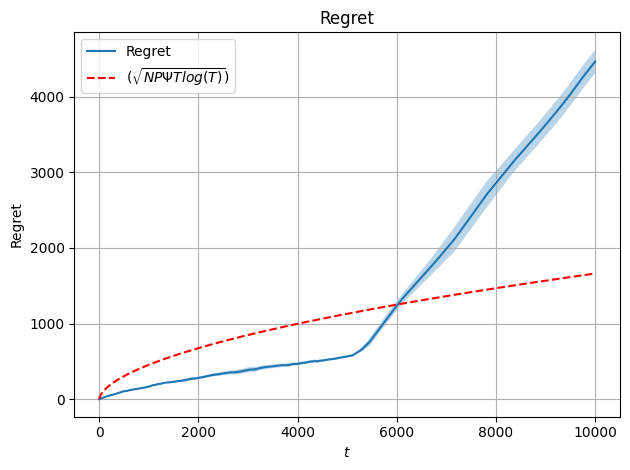

In [238]:
plt.plot(np.arange(T), average_regret, label=f'Regret')
plt.fill_between(
    np.arange(T),
    average_regret-regret_sd/np.sqrt(n_trials),
    average_regret+regret_sd/np.sqrt(n_trials),
    alpha=0.3
)

t = np.arange(1, T + 1)  # da 1 per evitare log(0)
theoretical_curve = (N*P*T/W*t*np.log(t))**(1/2)
plt.plot(t - 1, theoretical_curve, label="$(\sqrt{NPΨTlog(T)})$", linestyle="--", color="red")

plt.xlabel("$t$")
plt.ylabel("Regret")
plt.title("Regret")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()